In [1]:
from reservoir import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load sample data

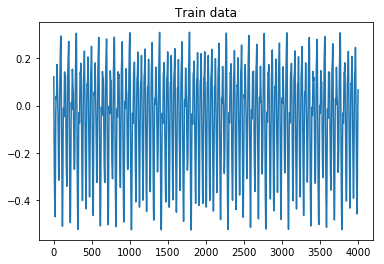

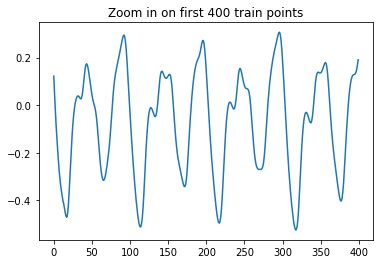

In [2]:
data = np.loadtxt('../Datasets/MackeyGlass_t17.txt')

train = data[:4000].reshape(-1, 1)
test = data[4000:6000].reshape(-1, 1)
plt.title("Train data")
plt.plot(train)
plt.show()
plt.title("Zoom in on first 400 train points")
plt.plot(train[:400])
plt.show()

### Add noise

In [ ]:
# Define noisy data for Bayesian Optimization
snr = 4
noise_std = np.sqrt(train.std(ddof=1)**2 / snr)

print('Standard deviation of noise is:', noise_std)
noisy_train = train + np.random.normal(0, noise_std, size=train.shape)
noisy_test = test + np.random.normal(0, noise_std, size=test.shape)
plt.plot(noisy_train[:400])
plt.show()

### Combine multiple series for evaluation if desired

In [ ]:
multiple_train = np.hstack((train, noisy_train))
multiple_test = np.hstack((test, noisy_test))

### Set bounds

In [ ]:
bounds = [
    {'name': 'input_scaling', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'feedback_scaling', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'leaking_rate', 'type': 'continuous', 'domain': (0, 1)}, 
    {'name': 'spectral_radius', 'type': 'continuous', 'domain': (0, 1.25)},
    {'name': 'regularization', 'type': 'continuous', 'domain': (-12, 1)},
    {'name': 'connectivity', 'type': 'continuous', 'domain': (-3, 0)},
    {'name': 'n_nodes', 'type': 'continuous', 'domain': (100, 1500)}
]

### Optimize

In [ ]:
# Set optimization parameters
esn_cv = EchoStateNetworkCV(bounds=bounds,
                            initial_samples=200,
                            subsequence_length=1000,
                            eps=1e-8,
                            cv_samples=1, 
                            max_iterations=100, 
                            scoring_method='tanh',
                            verbose=True)

In [ ]:
# Optimize (this may take a while!)
best_arguments = esn_cv.optimize(y=multiple_train)

In [ ]:
# Train best model(s)
esn = EchoStateNetwork(**best_arguments)
esn.train(y=train)

esn2 = EchoStateNetwork(**best_arguments)
esn2.train(y=noisy_train)

In [ ]:
# Test
score = esn.test(y=test, scoring_method='rmse')
score2 = esn.test(y=noisy_test, scoring_method='rmse')
print(score)
print(score2)

### Inspect performance

In [ ]:
# Diagnostic plots
plt.plot(esn.predict(100), label='Predicted')
plt.plot(test[:100], label='Ground truth')
plt.title('Prediction on next 100 steps')
plt.legend()
plt.show()

plt.plot(esn2.predict(100), label='Predicted')
plt.plot(noisy_test[:100], label='Ground truth')
plt.title('Prediction on next 100 steps')
plt.legend()
plt.show()

## Manually tuned example, for comparison

In [7]:
# Regular approach
esn = EchoStateNetwork(n_nodes=1000, connectivity=0.01, input_scaling=0.5, feedback_scaling=0.5, leaking_rate=0.3, 
                       spectral_radius=1.25, regularization=1e-8, feedback=True)
complete_data, y_used, burn_in = esn.train(y=train, burn_in=100)

0.009201272798670744

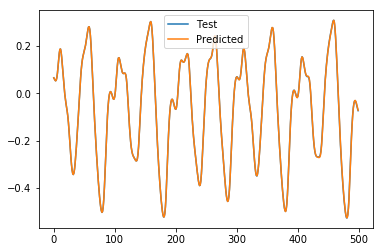

In [8]:
# Prediction sample for ground truth
plt.plot(test[:500], label='Test')
plt.plot(esn.predict(500), label='Predicted')
plt.legend()
esn.test(y=test[:500], scoring_method='nrmse')

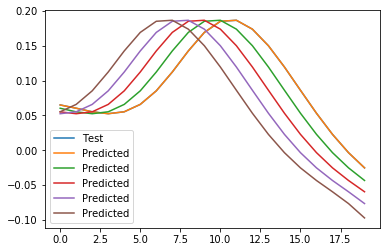

In [9]:
# Stepwise prediction
five_step_prediction = esn.predict_stepwise(test[:20], steps_ahead=5)
plt.plot(test[:20], label='Test')
plt.plot(five_step_prediction, label='Predicted')
plt.legend();

In [10]:
five_step_prediction

array([[ 0.0648784 ,  0.06016809,  0.05499899,  0.05230728,  0.05507833],
       [ 0.06020649,  0.05502401,  0.05231115,  0.05506602,  0.06569299],
       [ 0.05505207,  0.05232878,  0.05506872,  0.06568603,  0.0851653 ],
       [ 0.05234945,  0.05508049,  0.06568683,  0.08516069,  0.11218608],
       [ 0.0550914 ,  0.06569212,  0.08516016,  0.11218371,  0.14244413],
       [ 0.06569225,  0.08516021,  0.11218369,  0.1424441 ,  0.1690513 ],
       [ 0.0851584 ,  0.11218323,  0.14244461,  0.16905171,  0.18503331],
       [ 0.11218197,  0.14244448,  0.16905225,  0.18503362,  0.18649038],
       [ 0.14243317,  0.16905305,  0.1850402 ,  0.18649342,  0.17371271],
       [ 0.16903434,  0.18504465,  0.1865072 ,  0.17371831,  0.14992262],
       [ 0.18502921,  0.1865129 ,  0.17373163,  0.14992769,  0.11936503],
       [ 0.1864946 ,  0.17373993,  0.14994507,  0.11937158,  0.08599583],
       [ 0.17371497,  0.14995776,  0.119397  ,  0.0860058 ,  0.05298602],
       [ 0.14993688,  0.11940856,  0.0